# Fraiser Dialog Speaker Classification

### On a Raspberry Pi 3 (DietPi Buster image)

Data Source: https://www.kaggle.com/sulabhbista/frasier-dialogs/data#script.csv

Columns:
- url: URL from where the dialog was downloaded
- cast: Name of the cast
- dialog: Dialog utterance by the cast
- timestamp: Date/time when the a specific row was downloaded

Tasks:
- Explore the text data
  - E.g. Check the top words used by each speaker
- Balance classes, if applicable
- Tokenise the data and train a classifier to predict the speaker
 - Use pre-trained word embedding
 - Use own word embedding

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import pickle
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('./script.csv')
df.head()

,url,cast,dialog,timestamp
0,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"[firmly] Listen to yourself, Bob! You follow ...",2018-04-13 07:43:16
1,http://www.kacl780.net/frasier/transcripts/sea...,Roz,"Yes, Dr Crane. On line four, we have Russell ...",2018-04-13 07:43:16
2,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"[presses a button] Hello, Russell. This is Dr...",2018-04-13 07:43:16
3,http://www.kacl780.net/frasier/transcripts/sea...,Russell,"[v.o.] Well, I've been feeling sort of, uh, yo...",2018-04-13 07:43:16
4,http://www.kacl780.net/frasier/transcripts/sea...,Frasier,"Er, Russell, we're just about at the end of ou...",2018-04-13 07:43:16


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63945 entries, 0 to 63944
Data columns (total 4 columns):
url          63945 non-null object
cast         63943 non-null object
dialog       63788 non-null object
timestamp    63945 non-null object
dtypes: object(4)
memory usage: 999.2+ KB


In [5]:
# dropping some unneeded columns

df.drop(columns=['url', 'timestamp'], inplace=True)
df.head()

,cast,dialog
0,Frasier,"[firmly] Listen to yourself, Bob! You follow ..."
1,Roz,"Yes, Dr Crane. On line four, we have Russell ..."
2,Frasier,"[presses a button] Hello, Russell. This is Dr..."
3,Russell,"[v.o.] Well, I've been feeling sort of, uh, yo..."
4,Frasier,"Er, Russell, we're just about at the end of ou..."


In [6]:
# cleaning some NaN columns
df.dropna(inplace=True)

In [7]:
df['cast'].unique()

array(['Frasier', 'Roz', 'Russell', ...,
       'Rachel: You can do me one quick favor',
       'leaving is because I want what all of you have now', 'Pilot'],
      dtype=object)

In [8]:
# some cast values contain dialog, let's focus on cast with top 5 value_counts

main_cast_counts = df['cast'].value_counts()[:5]
main_cast_counts

Frasier    21088
Niles      10178
Martin      7629
Daphne      5243
Roz         4735
Name: cast, dtype: int64

In [9]:
df_main = df.loc[df['cast'].isin(main_cast_counts.keys())]
df_main.head()

,cast,dialog
0,Frasier,"[firmly] Listen to yourself, Bob! You follow ..."
1,Roz,"Yes, Dr Crane. On line four, we have Russell ..."
2,Frasier,"[presses a button] Hello, Russell. This is Dr..."
4,Frasier,"Er, Russell, we're just about at the end of ou..."
5,Roz,"No, we cut to the news thirty seconds ago."


## Data Exploration and Imbalance Checking

In [10]:
# There are 2x more Fraiser lines than the 2nd highest (Niles).
# Let's try to balance the dataset by sampling from the Fraiser rows
# Before we do that, let's see what the average dialog length is for Fraiser

In [11]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w\']+') # include aposptophes

tokens = df_main.loc[df_main['cast'] == 'Frasier', 'dialog'].apply(tokenizer.tokenize)
tokens

0        [firmly, Listen, to, yourself, Bob, You, follo...
2        [presses, a, button, Hello, Russell, This, is,...
4        [Er, Russell, we're, just, about, at, the, end...
6        [annoyed, rips, off, his, headphones, Oh, for,...
7        [Well, the, rest, of, the, show, was, pretty, ...
9        [Roz, in, the, trade, we, call, that, avoidanc...
11       [I, am, not, a, piece, of, Lalique, I, can, ha...
13       [takes, the, notepaper, You, say, my, brother,...
17       [looks, up, Oh, I'm, sorry, Niles, I, didn't, ...
19       [Oh, Niles, you're, a, psychiatrist, you, know...
21                                                   [And]
23       [Yes, I, know, what, you, think, about, everyt...
26                            [Two, cafe, latte, supremos]
27                                        [No, thank, you]
29       [I'm, fine, I, love, my, new, life, I, love, t...
31       [So, does, he, laughs, The, fresh, air's, good...
33                                           [Is, it, Da

In [12]:
# remove stopwords
def tokenise_no_stopwords(text):
    stoplist = set(stopwords.words('english'))
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w]+') # include aposptophes
    return [tok for tok in tokenizer.tokenize(text) if (tok.lower() not in stoplist)]

tokens = df_main.loc[df_main['cast'] == 'Frasier', 'dialog'].apply(tokenise_no_stopwords)
tokens

0        [firmly, Listen, Bob, follow, work, eavesdrop,...
2        [presses, button, Hello, Russell, Dr, Frasier,...
4        [Er, Russell, end, hour, Let, see, cut, chase,...
6        [annoyed, rips, headphones, Oh, crying, loud, ...
7        [Well, rest, show, pretty, good, Roz, says, no...
9        [Roz, trade, call, avoidance, change, subject,...
11              [piece, Lalique, handle, criticism, today]
13                [takes, notepaper, say, brother, called]
17       [looks, Oh, sorry, Niles, realise, stopped, ta...
19       [Oh, Niles, psychiatrist, know, like, listen, ...
21                                                      []
23       [Yes, know, think, everything, last, time, une...
26                            [Two, cafe, latte, supremos]
27                                                 [thank]
29       [fine, love, new, life, love, solitude, miss, ...
31                              [laughs, fresh, air, good]
33                                                   [Da

In [13]:
# plot wordcount distributions
def plot_wordcount_distribution(cast, df_input):
    tokens = df_input.loc[df_input['cast'] == cast, 'dialog'].apply(tokenise_no_stopwords)
    lengths = tokens.apply(len)
    sns.distplot(lengths, kde=False)
    plt.xlabel(cast)
    plt.show()
    return lengths.describe()

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


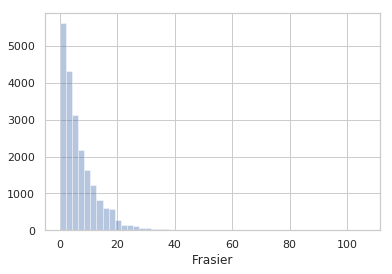

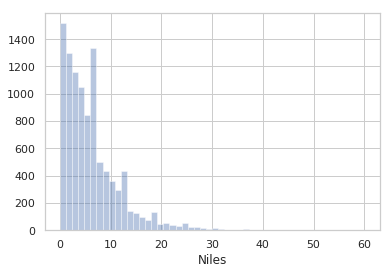

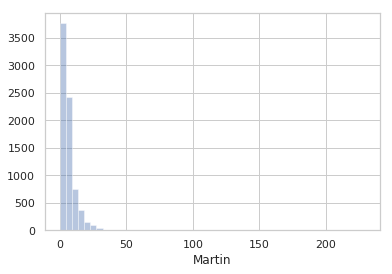

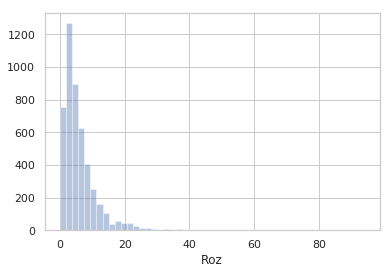

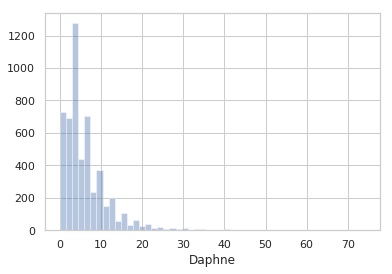

In [14]:
stats = pd.DataFrame({'Frasier': plot_wordcount_distribution('Frasier', df_main)})
stats = pd.concat([stats, pd.DataFrame({'Niles': plot_wordcount_distribution('Niles', df_main)})], axis=1) # col-wise concat
stats = pd.concat([stats, pd.DataFrame({'Martin': plot_wordcount_distribution('Martin', df_main)})], axis=1)
stats = pd.concat([stats, pd.DataFrame({'Roz': plot_wordcount_distribution('Roz', df_main)})], axis=1) 
stats = pd.concat([stats, pd.DataFrame({'Daphne': plot_wordcount_distribution('Daphne', df_main)})], axis=1)

In [15]:
# stats at a glance
stats

,Frasier,Niles,Martin,Roz,Daphne
count,21088.000000,10178.000000,7629.000000,4735.000000,5243.000000
mean,6.793484,6.218609,6.196618,5.760718,6.083349
std,6.559465,5.734493,6.491666,5.630727,5.980073
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000
50%,5.000000,5.000000,5.000000,4.000000,4.000000
75%,9.000000,8.000000,8.000000,8.000000,8.000000
max,106.000000,60.000000,229.000000,94.000000,74.000000


In [16]:
# 75% percentile is about 8-9 tokens
# The distributions are quite similar, so we will undersample from Frasier to balance the classes a bit more
# They don't have to be exactly the same.

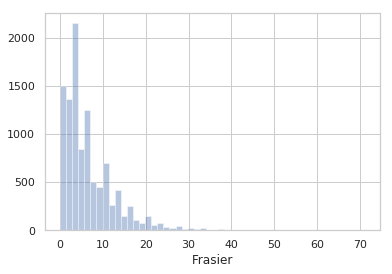

In [17]:
df_frasier_sampled = df_main.loc[df_main['cast'] == 'Frasier'].sample(frac=.5)

stats = pd.concat([stats, pd.DataFrame({'Frasier (sampled)': plot_wordcount_distribution('Frasier', df_frasier_sampled)})], axis=1)

In [18]:
# compare before and after undersampling.
stats

,Frasier,Niles,Martin,Roz,Daphne,Frasier (sampled)
count,21088.000000,10178.000000,7629.000000,4735.000000,5243.000000,10544.000000
mean,6.793484,6.218609,6.196618,5.760718,6.083349,6.803775
std,6.559465,5.734493,6.491666,5.630727,5.980073,6.601465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,5.000000,5.000000,5.000000,4.000000,4.000000,5.000000
75%,9.000000,8.000000,8.000000,8.000000,8.000000,9.000000
max,106.000000,60.000000,229.000000,94.000000,74.000000,71.000000


In [19]:
# create our dataset
df_main_balanced = df_frasier_sampled

cast = ['Niles', 'Martin', 'Roz', 'Daphne']
for c in cast:
    df_main_balanced = pd.concat([df_main_balanced, 
                                  df_main.loc[df_main['cast'] == c]])

In [20]:
df_main_balanced['cast'].value_counts()

Frasier    10544
Niles      10178
Martin      7629
Daphne      5243
Roz         4735
Name: cast, dtype: int64

In [21]:
# save a snapshot of our balanced dataframe
pickle.dump(df_main_balanced, open('./df_main_balanced.pkl', 'wb'))

## Tokenisation

In [22]:
df_main_balanced = pickle.load(open('./df_main_balanced.pkl', 'rb'))
df_main_balanced.head()

,cast,dialog
31010,Frasier,What the hell is that?
54907,Frasier,"It is! Oh, Niles, this just gets better and b..."
57139,Frasier,There we are.
51873,Frasier,"Listen, I'm sorry that I ruined your evening."
58703,Frasier,"Well, then you should have said something, now..."


In [23]:
def tokenise_no_stopwords_join(text):
    stoplist = set(stopwords.words('english'))
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w]+') # include aposptophes
    return ' '.join([tok for tok in tokenizer.tokenize(text) if (tok.lower() not in stoplist)])

df_main_balanced['dialog_nostop'] = df_main_balanced['dialog'].apply(tokenise_no_stopwords_join)

In [24]:
df_main_balanced.head()

,cast,dialog,dialog_nostop
31010,Frasier,What the hell is that?,hell
54907,Frasier,"It is! Oh, Niles, this just gets better and b...",Oh Niles gets better better Balanced skin soci...
57139,Frasier,There we are.,
51873,Frasier,"Listen, I'm sorry that I ruined your evening.",Listen sorry ruined evening
58703,Frasier,"Well, then you should have said something, now...",Well said something deep unscramble egg Niles


In [25]:
# save a snapshot of our balanced dataframe without stopwords
pickle.dump(df_main_balanced, open('./df_main_balanced_nostop.pkl', 'wb'))

In [26]:
X = df_main_balanced['dialog_nostop']

le_y = LabelEncoder()
y = le_y.fit_transform(df_main_balanced['cast'])
y = tf.keras.utils.to_categorical(y)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.1,
                                                    random_state=42)

In [28]:
# Tokenise, limiting to most frequent 5000 words
max_vocab_length = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_length, filters='')
tokenizer.fit_on_texts(X_train)

# Create sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)

# Set seq length near 75th percentile
seq_length = 11

# Pad sequences with pre-padding so that activations will be non-zero towards end of sequence
X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=seq_length, 
                                                            padding='pre')
X_train_seq.shape, X_train_seq

((34496, 11), array([[   0,    0,  283, ...,   12, 3073,  237],
        [   0,    0,    0, ...,   94,  126,   56],
        [   0,    0,    0, ...,   24, 2183, 4546],
        ...,
        [   0,    0,    0, ...,  610, 2522,  938],
        [   0,    0,    0, ...,    0, 2309,  112],
        [   0,    0,    0, ...,    0,    0,   21]]))

In [29]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=seq_length,
                                                           padding='pre')
X_test_seq.shape, X_test_seq

((3833, 11), array([[   0,    0,    0, ...,    0,    0,   35],
        [   0,    0,    0, ...,   71,   26, 1185],
        [   0,    0,    0, ...,   35,   98,  173],
        ...,
        [   7,  212, 2639, ...,  646,  172,  132],
        [   0,    0,    0, ...,    0, 1290, 1174],
        [   0,    0,    0, ...,   33,   45,  298]]))

In [30]:
len(tokenizer.index_word)

17872

In [31]:
# save our tokenizer, label encoder, etc
preprocessors = {
    'le_y': le_y,
    'tokenizer': tokenizer
}

pickle.dump(preprocessors, open('./fraiser_preprocessors.pkl', 'wb'))

In [35]:
# save our training and test sets
dataset = {
    'X_train_seq': X_train_seq,
    'y_train': y_train,
    'X_test_seq': X_test_seq,
    'y_test': y_test
}

pickle.dump(dataset, open('./fraiser_seq_datasets.pkl', 'wb'))

## Model Engineering

- Simple 1D convolutional layer
- Simple GRU layer

In [35]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Dense, Embedding, GlobalAvgPool1D, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os, datetime

In [36]:
# Simple CNN model with non-pre-trained Embedding
cnn_simple = Sequential()
cnn_simple.add(Embedding(max_vocab_length+1, 50, input_length=seq_length))
cnn_simple.add(Conv1D(16, kernel_size=5, padding='same', activation='relu'))
cnn_simple.add(GlobalAvgPool1D())
cnn_simple.add(Dense(5, activation='softmax'))
cnn_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 50)            250050    
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 16)            4016      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 254,151
Trainable params: 254,151
Non-trainable params: 0
_________________________________________________________________


In [37]:
log_dir = os.path.join('./logs', 'fraiser', 'cnn_simple',
                                   datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=log_dir)
mc = ModelCheckpoint('fraiser_cnn_simple.h5', save_best_only=True, monitor='val_accuracy')

cnn_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_simple.fit(X_train_seq, y_train, validation_split=.1,
                       batch_size=128, epochs=15, callbacks=[tb, mc])

Train on 31046 samples, validate on 3450 samples
Epoch 1/15
31046/31046 [==============================] - 48s 2ms/sample - loss: 1.5202 - accuracy: 0.3182 - val_loss: 1.4486 - val_accuracy: 0.3786
Epoch 2/15
31046/31046 [==============================] - 26s 826us/sample - loss: 1.3575 - accuracy: 0.4326 - val_loss: 1.3650 - val_accuracy: 0.4151
Epoch 3/15
31046/31046 [==============================] - 19s 611us/sample - loss: 1.2403 - accuracy: 0.4872 - val_loss: 1.3540 - val_accuracy: 0.4255
Epoch 4/15
31046/31046 [==============================] - 19s 622us/sample - loss: 1.1639 - accuracy: 0.5223 - val_loss: 1.3581 - val_accuracy: 0.4246
Epoch 5/15
31046/31046 [==============================] - 18s 588us/sample - loss: 1.1120 - accuracy: 0.5470 - val_loss: 1.3903 - val_accuracy: 0.4183
Epoch 6/15
31046/31046 [==============================] - 18s 571us/sample - loss: 1.0745 - accuracy: 0.5602 - val_loss: 1.4169 - val_accuracy: 0.4229
Epoch 7/15
31046/31046 [=======================

In [38]:
best_model = load_model('fraiser_cnn_simple.h5')
best_model.evaluate(X_test_seq, y_test, verbose=0) # loss, accuracy

[1.3546042654740105, 0.41455778]

In [39]:
# Simple RNN model with non-pre-trained Embedding
rnn_simple = Sequential()
rnn_simple.add(Embedding(max_vocab_length+1, 50, input_length=seq_length))
rnn_simple.add(GRU(16))
rnn_simple.add(Dense(5, activation='softmax'))
rnn_simple.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 11, 50)            250050    
_________________________________________________________________
gru (GRU)                    (None, 16)                3264      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 253,399
Trainable params: 253,399
Non-trainable params: 0
_________________________________________________________________


In [40]:
log_dir = os.path.join('./logs', 'fraiser', 'rnn_simple',
                                   datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=log_dir)
mc = ModelCheckpoint('fraiser_rnn_simple.h5', save_best_only=True, monitor='val_accuracy')

rnn_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_simple.fit(X_train_seq, y_train, validation_split=.1,
                       batch_size=128, epochs=15, callbacks=[tb, mc])

Train on 31046 samples, validate on 3450 samples
Epoch 1/15
31046/31046 [==============================] - 113s 4ms/sample - loss: 1.5127 - accuracy: 0.3250 - val_loss: 1.4256 - val_accuracy: 0.3719
Epoch 2/15
31046/31046 [==============================] - 294s 9ms/sample - loss: 1.3245 - accuracy: 0.4436 - val_loss: 1.3648 - val_accuracy: 0.4136
Epoch 3/15
31046/31046 [==============================] - 49s 2ms/sample - loss: 1.2137 - accuracy: 0.4993 - val_loss: 1.3828 - val_accuracy: 0.4212
Epoch 4/15
31046/31046 [==============================] - 29s 941us/sample - loss: 1.1432 - accuracy: 0.5336 - val_loss: 1.4092 - val_accuracy: 0.4220
Epoch 5/15
31046/31046 [==============================] - 29s 924us/sample - loss: 1.0960 - accuracy: 0.5554 - val_loss: 1.4360 - val_accuracy: 0.4209
Epoch 6/15
31046/31046 [==============================] - 28s 894us/sample - loss: 1.0572 - accuracy: 0.5711 - val_loss: 1.4727 - val_accuracy: 0.4180
Epoch 7/15
31046/31046 [=========================

In [41]:
best_model = load_model('fraiser_rnn_simple.h5')
best_model.evaluate(X_test_seq, y_test, verbose=0) # loss, accuracy

[1.3991612650351024, 0.4268197]

## Pre-trained Embedding

- Glove: https://keras.io/examples/pretrained_word_embeddings/

```
wget https://nlp.stanford.edu/data/glove.6B.zip
unzip glove.6B.zip
```

- Pre-load in Embedding for each model

In [43]:
from tensorflow.keras.initializers import Constant

In [44]:
# Indexing word vectors
embeddings_index = {}
with open('./glove.6B.50d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [45]:
# prepare embedding matrix
embedding_dim = 50
word_index = tokenizer.word_index
num_words = min(max_vocab_length, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_vocab_length:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
pretrained_embedding = Embedding(num_words, embedding_dim, input_length=seq_length,
                            embeddings_initializer=Constant(embedding_matrix),
                            trainable=False)

In [46]:
# Simple CNN model with pre-trained Embedding
cnn_simple_pt = Sequential()
cnn_simple_pt.add(pretrained_embedding)
cnn_simple_pt.add(Conv1D(16, kernel_size=5, padding='same', activation='relu'))
cnn_simple_pt.add(GlobalAvgPool1D())
cnn_simple_pt.add(Dense(5, activation='softmax'))

# save the model and reload kernel so that we can continue training
# this is because loading the word vectors can put a strain in memory
cnn_simple_pt.save('fraiser_cnn_simple_pt.h5')

cnn_simple_pt.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 11, 50)            250000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 16)            4016      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 254,101
Trainable params: 4,101
Non-trainable params: 250,000
_________________________________________________________________


In [47]:
# Simple RNN model with pre-trained Embedding
rnn_simple_pt = Sequential()
rnn_simple_pt.add(pretrained_embedding)
rnn_simple_pt.add(GRU(16))
rnn_simple_pt.add(Dense(5, activation='softmax'))

# save the model and reload kernel so that we can continue training
rnn_simple_pt.save('fraiser_rnn_simple_pt.h5')

rnn_simple_pt.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 11, 50)            250000    
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                3264      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 253,349
Trainable params: 3,349
Non-trainable params: 250,000
_________________________________________________________________


### Reload kernel to continue training

Due to limited memory on the Raspberry Pi, we should re-load the kernel at this point so that memory can be freed.

In [33]:
# reload kernel so that we can continue training
# import some libraries here since we are reloading the kernel
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os, datetime
import pickle

In [36]:
# load our saved datasets
dataset = pickle.load(open('./fraiser_seq_datasets.pkl', 'rb'))

X_train_seq = dataset['X_train_seq']
y_train = dataset['y_train']
X_test_seq = dataset['X_test_seq']
y_test = dataset['y_test']

In [37]:
# load our saved models and start training
cnn_simple_pt = load_model('fraiser_cnn_simple_pt.h5')

log_dir = os.path.join('./logs', 'fraiser', 'cnn_simple_pt',
                                   datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=log_dir)
mc = ModelCheckpoint('fraiser_cnn_simple_pt.h5', save_best_only=True, monitor='val_accuracy')

cnn_simple_pt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_simple_pt.fit(X_train_seq, y_train, validation_split=.1,
                       batch_size=128, epochs=15, callbacks=[tb, mc])

Train on 31046 samples, validate on 3450 samples
Epoch 1/15
31046/31046 [==============================] - 17s 544us/sample - loss: 1.5600 - accuracy: 0.2852 - val_loss: 1.5491 - val_accuracy: 0.2878
Epoch 2/15
31046/31046 [==============================] - 15s 476us/sample - loss: 1.5314 - accuracy: 0.3097 - val_loss: 1.5329 - val_accuracy: 0.2997
Epoch 3/15
31046/31046 [==============================] - 14s 451us/sample - loss: 1.5152 - accuracy: 0.3228 - val_loss: 1.5247 - val_accuracy: 0.3049
Epoch 4/15
31046/31046 [==============================] - 14s 451us/sample - loss: 1.5041 - accuracy: 0.3323 - val_loss: 1.5129 - val_accuracy: 0.3220
Epoch 5/15
31046/31046 [==============================] - 9s 299us/sample - loss: 1.4955 - accuracy: 0.3405 - val_loss: 1.5078 - val_accuracy: 0.3171
Epoch 6/15
31046/31046 [==============================] - 12s 401us/sample - loss: 1.4879 - accuracy: 0.3448 - val_loss: 1.5007 - val_accuracy: 0.3301
Epoch 7/15
31046/31046 [======================

In [38]:
best_model = load_model('fraiser_cnn_simple_pt.h5')
best_model.evaluate(X_test_seq, y_test, verbose=0) # loss, accuracy

[1.485282383169109, 0.33889905]

In [39]:
rnn_simple_pt = load_model('fraiser_rnn_simple_pt.h5')

log_dir = os.path.join('./logs', 'fraiser', 'rnn_simple_pt',
                                   datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=log_dir)
mc = ModelCheckpoint('fraiser_rnn_simple_pt.h5', save_best_only=True, monitor='val_accuracy')

rnn_simple_pt.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn_simple_pt.fit(X_train_seq, y_train, validation_split=.1,
                       batch_size=128, epochs=15, callbacks=[tb, mc])

Train on 31046 samples, validate on 3450 samples
Epoch 1/15
31046/31046 [==============================] - 189s 6ms/sample - loss: 1.5656 - accuracy: 0.2815 - val_loss: 1.5517 - val_accuracy: 0.2838
Epoch 2/15
31046/31046 [==============================] - 41s 1ms/sample - loss: 1.5318 - accuracy: 0.3101 - val_loss: 1.5301 - val_accuracy: 0.3029
Epoch 3/15
31046/31046 [==============================] - 33s 1ms/sample - loss: 1.5109 - accuracy: 0.3255 - val_loss: 1.5094 - val_accuracy: 0.3113
Epoch 4/15
31046/31046 [==============================] - 35s 1ms/sample - loss: 1.4897 - accuracy: 0.3441 - val_loss: 1.4868 - val_accuracy: 0.3357
Epoch 5/15
31046/31046 [==============================] - 36s 1ms/sample - loss: 1.4713 - accuracy: 0.3550 - val_loss: 1.4727 - val_accuracy: 0.3528
Epoch 6/15
31046/31046 [==============================] - 24s 783us/sample - loss: 1.4587 - accuracy: 0.3624 - val_loss: 1.4637 - val_accuracy: 0.3525
Epoch 7/15
31046/31046 [==============================

In [40]:
best_model = load_model('fraiser_rnn_simple_pt.h5')
best_model.evaluate(X_test_seq, y_test, verbose=0) # loss, accuracy

[1.4476444168561065, 0.3675972]

In [ ]:
# train longer
rnn_simple_pt.fit(X_train_seq, y_train, validation_split=.1,
                       batch_size=128, epochs=50, callbacks=[tb, mc])